Import the necessary libraries

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.ddpg.policies import MlpPolicy


Select the environment

In [2]:
env = gym.make("MountainCarContinuous-v0")

Make the model use a NVIDIA GPU by setting the device to 'cuda'

In [7]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("No GPU devices found.")


No GPU devices found.


Configure DDPG

In [8]:
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

Select the model

In [9]:
model = DDPG(MlpPolicy, env, action_noise=action_noise, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Train model

In [16]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggerCallback, self).__init__(verbose)
        self.rewards = []
        self.cumulative_rewards = []

    def _on_step(self) -> bool:
        self.rewards.append(self.locals["rewards"])
        if self.locals["dones"]: 
            self.cumulative_rewards.append(np.sum(self.rewards))
            self.rewards = []  
        return True

reward_logger = RewardLoggerCallback()

model.learn(total_timesteps=10000, callback=reward_logger)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -1.75    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 181      |
|    time_elapsed    | 22       |
|    total_timesteps | 3996     |
| train/             |          |
|    actor_loss      | -0.00985 |
|    critic_loss     | 1.07e-08 |
|    learning_rate   | 0.001    |
|    n_updates       | 23695    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -1.38    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 177      |
|    time_elapsed    | 44       |
|    total_timesteps | 7992     |
| train/             |          |
|    actor_loss      | -0.00801 |
|    critic_loss     | 3.36e-09 |
|    learning_rate   | 0.001    |
|    n_updates       | 27691    |
--------------

Evaluate and test

In [17]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

Mean reward: -0.0017780000000000005 +/- 4.336808689942018e-19


Plotting the learning curve

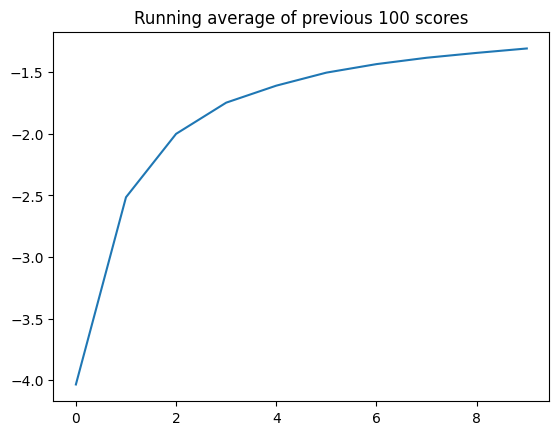

In [18]:
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

episode_rewards = reward_logger.cumulative_rewards
episodes = list(range(len(episode_rewards)))
plot_learning_curve(episodes, episode_rewards, 'ddpg_learning_curve.png')


Hyperparameter tuning

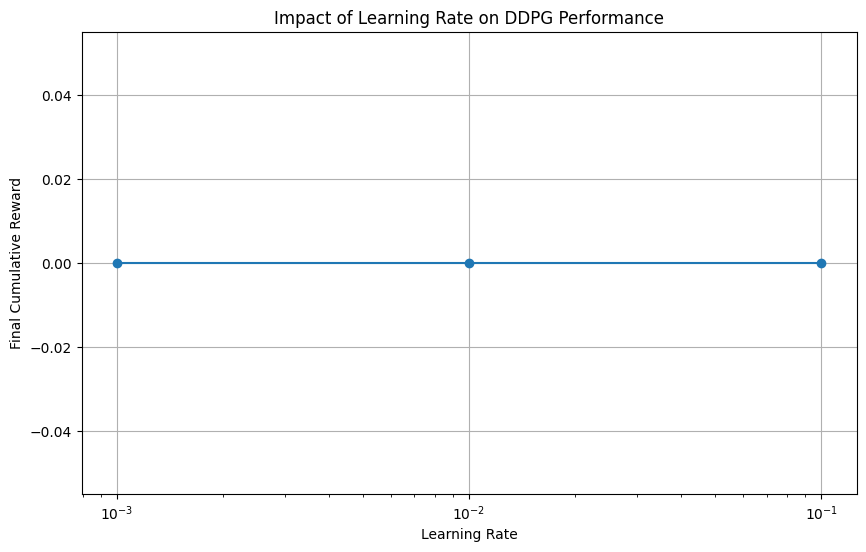

In [15]:
learning_rates = [0.001, 0.01, 0.1]
final_rewards = [0, 0, 0] # replace this with actual rewards

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, final_rewards, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Cumulative Reward')
plt.title('Impact of Learning Rate on DDPG Performance')
plt.xscale('log')
plt.grid(True)

plt.show()
